# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import fnmatch, glob

# Display all columns of pandas dataframe
pd.set_option('display.max_columns', None)

## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns that will be used to classification are in the list `alert_name`.

In [2]:
head_filenames = fnmatch.filter(glob.glob('data_rn/*'), '*HEAD.FITS.gz')
classes = ['SNIa', 'SNIbc', 'SNII']  # These are the classes that will be classified

# The following columns are the ones that will be used for classification
alert_name = ['SNID', 'RA', 'DEC', 'NOBS', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
            'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
            'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
            'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
            'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y','HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
            'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
            'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
            'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
            'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR']

In [28]:
classes

['SNIa', 'SNIbc', 'SNII']

In [27]:
cl = head_filenames[1].replace('_HEAD.FITS.gz', '').replace('data_rn/', '')
print(cl, 'SNIc' in cl)

SNIc+HostXT_V19 True


In [42]:
subclasses = [x.replace('_HEAD.FITS.gz', '').replace('data_rn/', '') for x in head_filenames]
subclasses

['SNIa-91bg',
 'SNIc+HostXT_V19',
 'SNIax',
 'SNII-NMF',
 'SNII-Templates',
 'SNIa-SALT2',
 'SNIcBL+HostXT_V19',
 'SNII+HostXT_V19',
 'SNIc-Templates',
 'SNIb-Templates',
 'SNIb+HostXT_V19']

In [45]:
for subclass in subclasses:
    print('SNIb' in subclass or 'SNIc' in subclass, subclass)

False SNIa-91bg
True SNIc+HostXT_V19
False SNIax
False SNII-NMF
False SNII-Templates
False SNIa-SALT2
True SNIcBL+HostXT_V19
False SNII+HostXT_V19
True SNIc-Templates
True SNIb-Templates
True SNIb+HostXT_V19


In [50]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.
    """
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())

    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    # Only alert_name columns are considered
    df = df[alert_name]


    subclass = filename.replace('_HEAD.FITS.gz', '').replace('data_rn/', '')  # Name of the subclass
    sclass = [subclass for x in range(len(df))]  # Array of strings containing the name of the subclass

    for _class_ in classes:
        if _class_ in subclass:
            subclass = _class_
        elif 'SNIc' in subclass or 'SNIb' in subclass:
            subclass = 'SNIbc'
    
    class_ = [subclass for x in range(len(df))]  # Array of strings containing the name of the class
    # A column containing the class and subclass are added
    df.insert(0, 'SUBCLASS', sclass)
    df.insert(0, 'CLASS', class_)

    return df


In [51]:
dataframes = []

for fn in head_filenames:
    dataframes.append(to_df(fn))

df_train = pd.concat(dataframes)
df_train

,CLASS,SUBCLASS,SNID,RA,DEC,NOBS,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_ZPHOT_Q000,HOSTGAL_ZPHOT_Q010,HOSTGAL_ZPHOT_Q020,HOSTGAL_ZPHOT_Q030,HOSTGAL_ZPHOT_Q040,HOSTGAL_ZPHOT_Q050,HOSTGAL_ZPHOT_Q060,HOSTGAL_ZPHOT_Q070,HOSTGAL_ZPHOT_Q080,HOSTGAL_ZPHOT_Q090,HOSTGAL_ZPHOT_Q100,HOSTGAL_MAG_u,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAG_Y,HOSTGAL_MAGERR_u,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL_MAGERR_Y,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_ZPHOT_Q000,HOSTGAL2_ZPHOT_Q010,HOSTGAL2_ZPHOT_Q020,HOSTGAL2_ZPHOT_Q030,HOSTGAL2_ZPHOT_Q040,HOSTGAL2_ZPHOT_Q050,HOSTGAL2_ZPHOT_Q060,HOSTGAL2_ZPHOT_Q070,HOSTGAL2_ZPHOT_Q080,HOSTGAL2_ZPHOT_Q090,HOSTGAL2_ZPHOT_Q100,HOSTGAL2_MAG_u,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAG_Y,HOSTGAL2_MAGERR_u,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR
0,SNIa,SNIa-91bg,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60895.4269,Y,-27.043575,33.173176
1,SNIa,SNIa-91bg,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60896.4165,Y,-24.575598,36.923645
2,SNIa,SNIa-91bg,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60927.4045,z,-9.708896,18.190941
3,SNIa,SNIa-91bg,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60937.3783,r,4.829184,5.221447
4,SNIa,SNIa-91bg,27528421,64.849535,-14.710349,117,0.035791,0.001790,0.423353,0.03838,64.848976,-14.710298,0.756289,-9.0,-9.0,0.423353,0.03838,0.192173,0.386893,0.399413,0.408433,0.416143,0.423353,0.430563,0.438273,0.447293,0.459813,0.654533,26.627020,25.489826,24.345381,24.051840,23.891758,23.780416,0.4919,0.0504,0.0172,0.0187,0.0280,0.0599,-999.0,-999.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,60944.3744,i,6.980536,3.225589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Visualization of data

A count plot and lighcurves (20 per class) are presented.

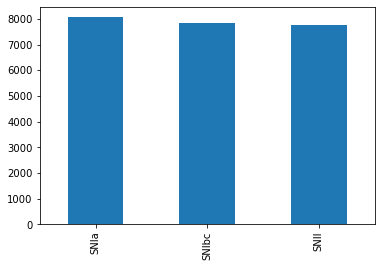

In [52]:
ax = df_train.groupby('SNID').max().CLASS.value_counts().plot.bar()

In [53]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}

bands = ['HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r',
         'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y',]

bands2 = ['HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g', 'HOSTGAl2_MAG_r',
         'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y',]


errors= ['HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
         'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y']

errors2= ['HOSTGA2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r',
         'HOSTGA2_MAGERR_i', 'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y']

In [54]:
def plot_lc(SNID, df, path=None):
    fig, ax = plt.subplots(figsize=(8,3))
    for idx, c in enumerate(colors.keys()):
      mask = (df.SNID == str(SNID)) & (df.BAND == c)
      if mask.sum() > 0:
        ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                      yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=3, lw=0, elinewidth=1, label=c)

    ax.set_xlabel('mjd')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None: fig.savefig(path+'lc_'+SNID+'.png')

In [55]:
# Obtaining the samples

np.random.seed(73)

snids = []  # In this array, the snid's of the objects will be stored.

for i in range(len(df_train.CLASS.unique())):
    snids.append(
        list(df_train.loc[df_train['CLASS'].isin([df_train.CLASS.unique()[i]])].sample(20).SNID))

snids = sum(snids, [])  # Transform list of lists into a list containing each snid

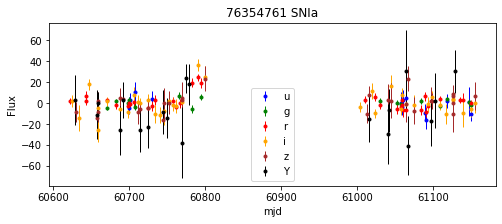

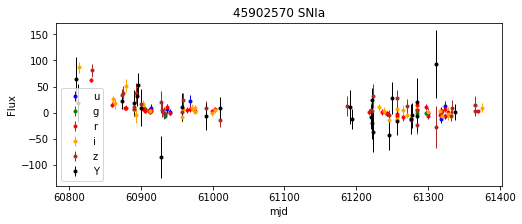

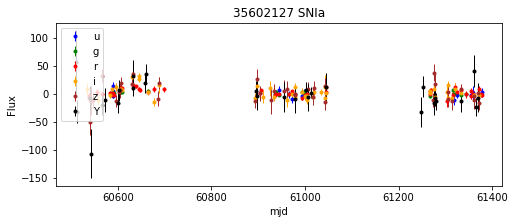

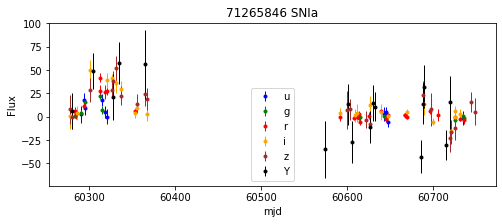

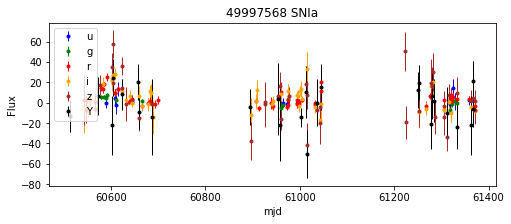

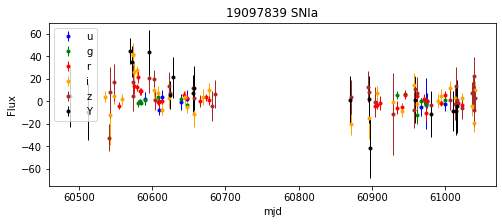

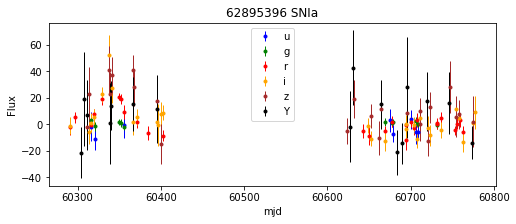

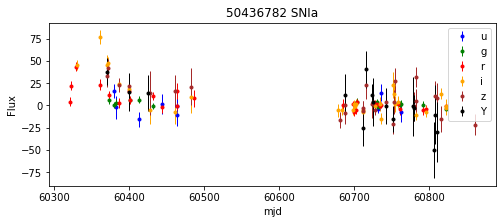

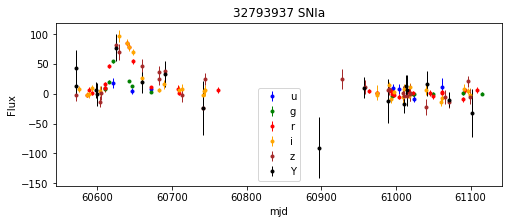

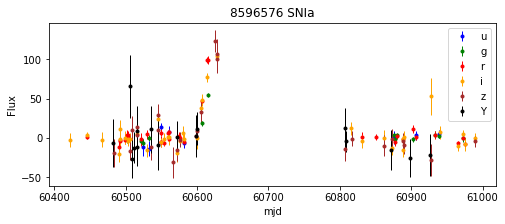

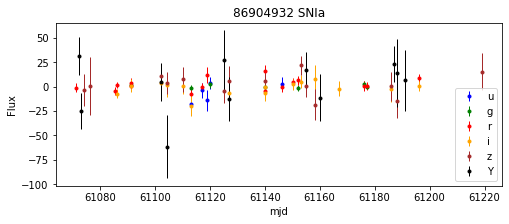

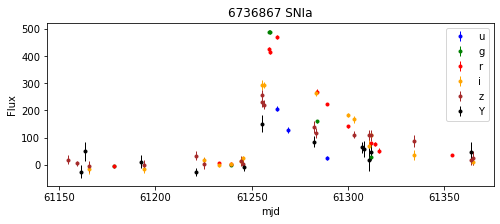

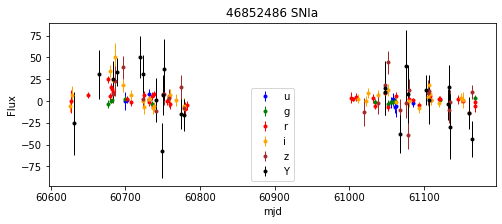

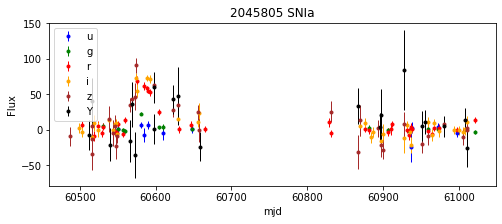

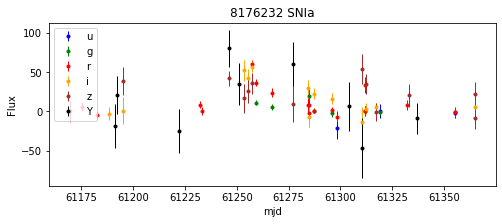

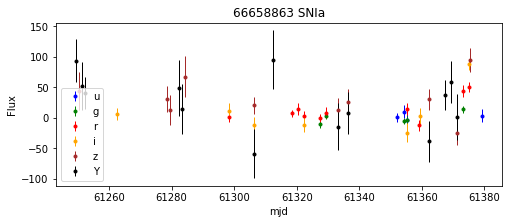

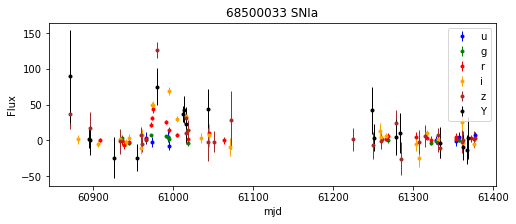

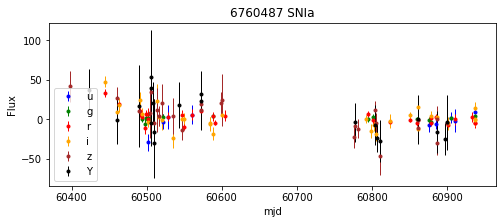

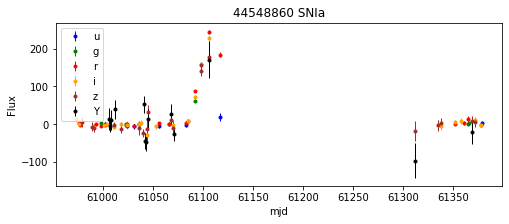

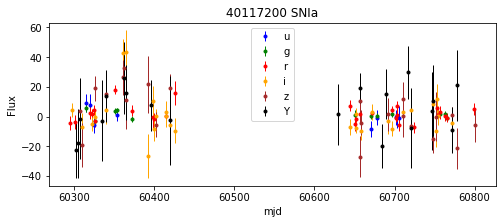

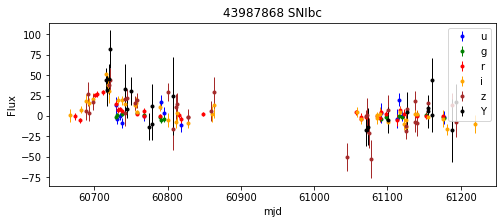

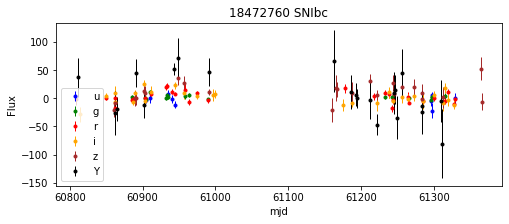

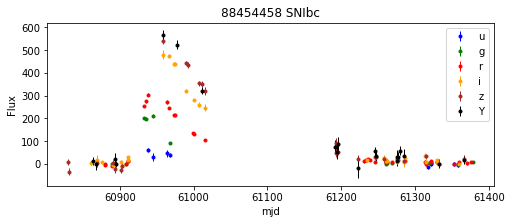

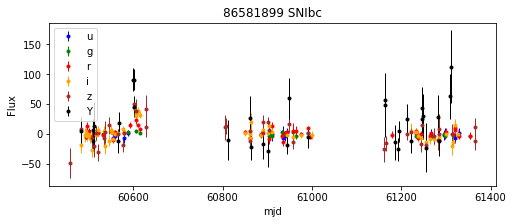

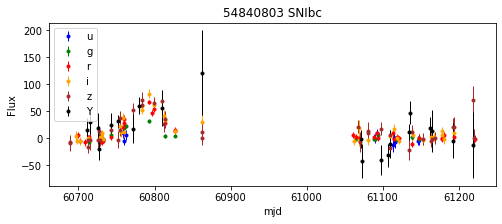

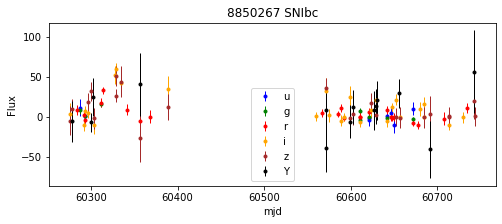

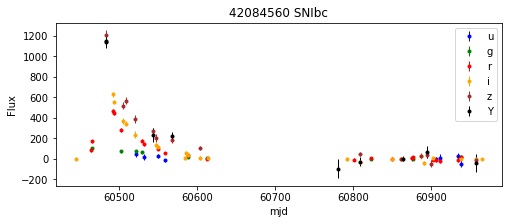

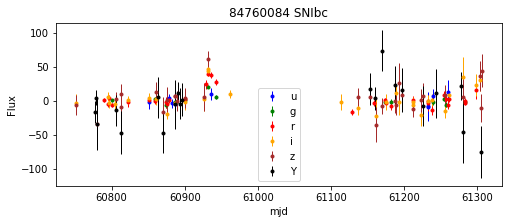

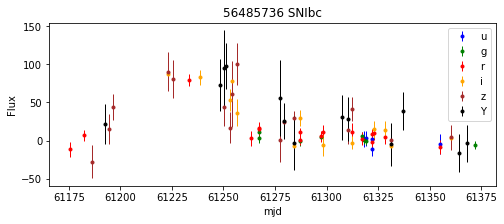

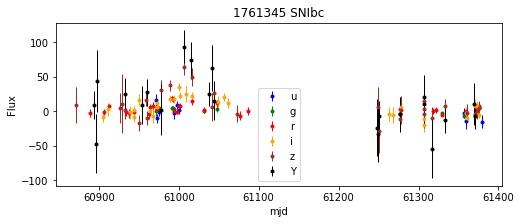

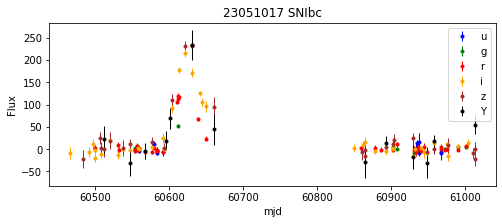

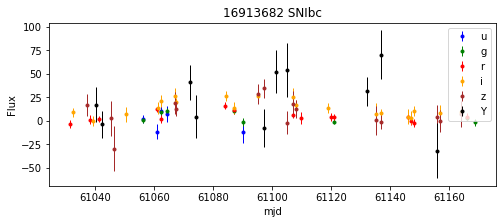

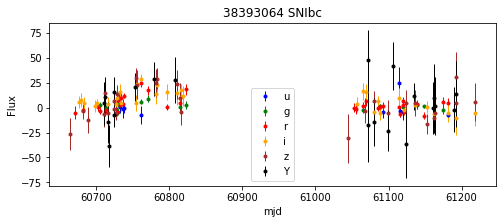

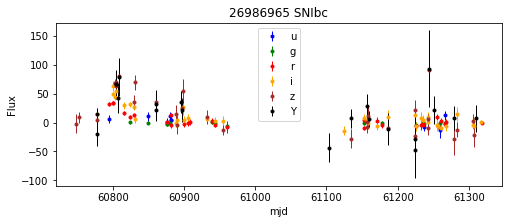

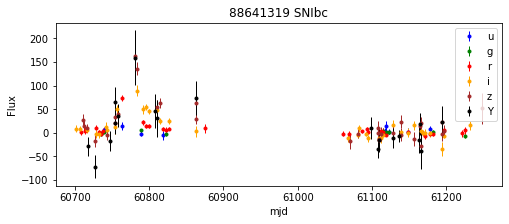

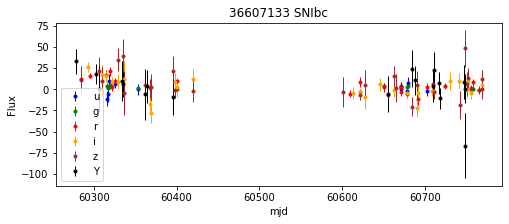

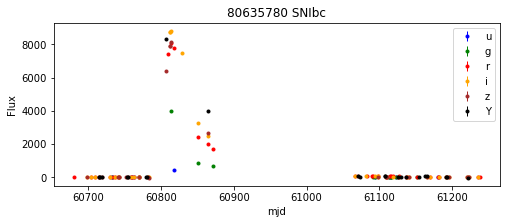

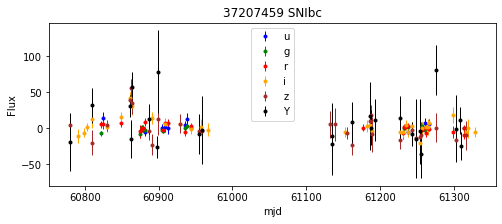

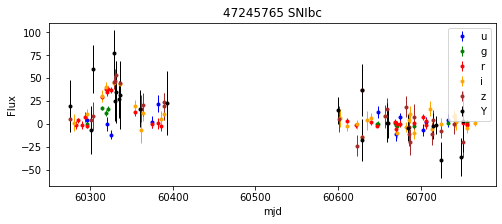

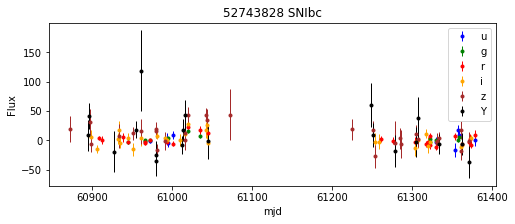

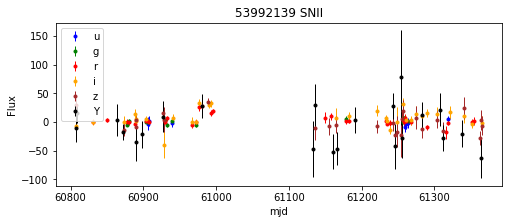

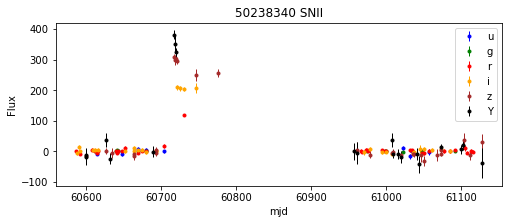

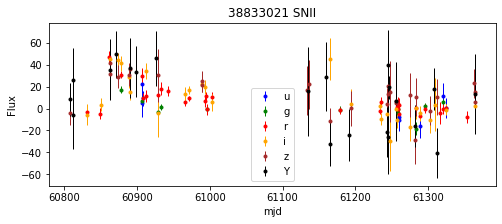

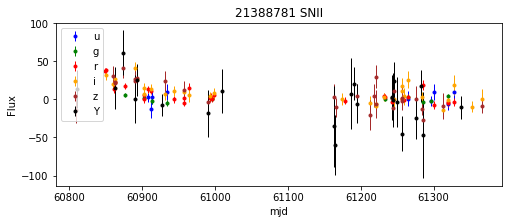

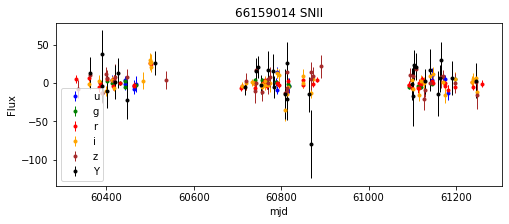

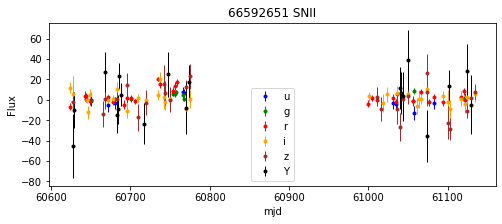

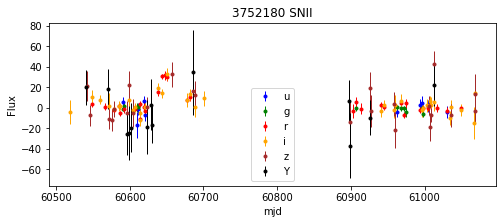

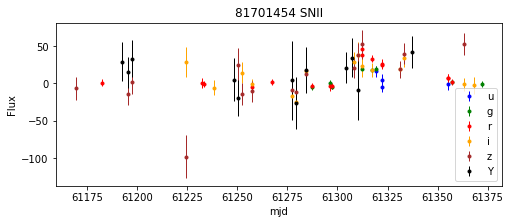

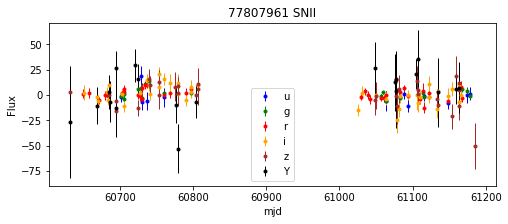

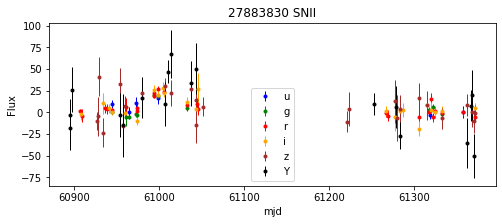

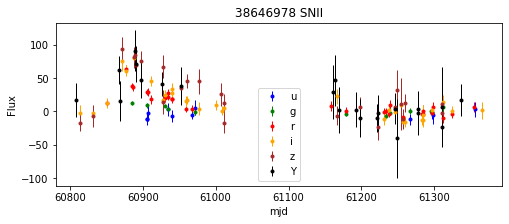

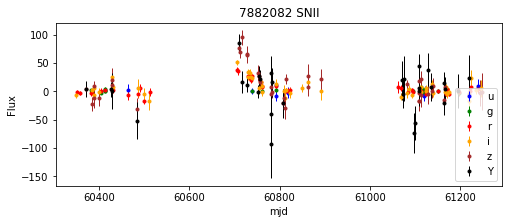

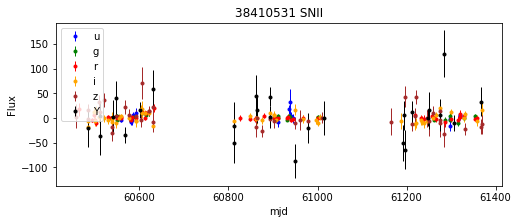

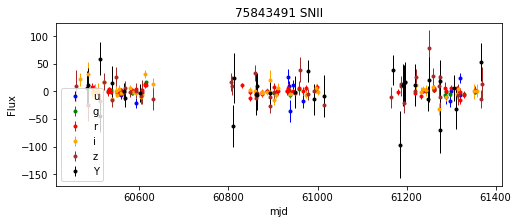

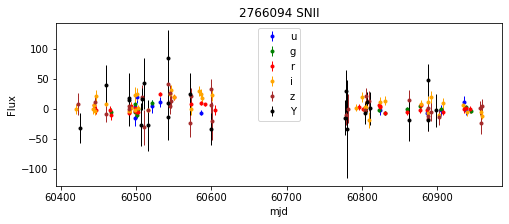

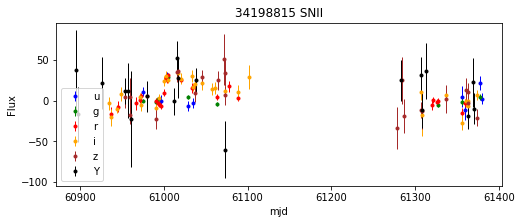

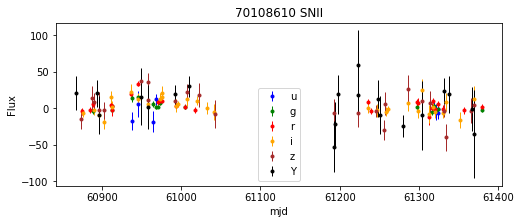

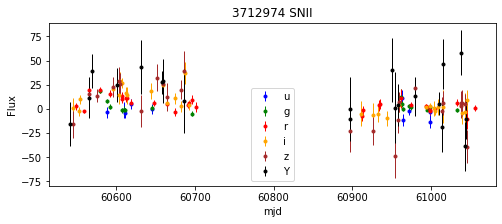

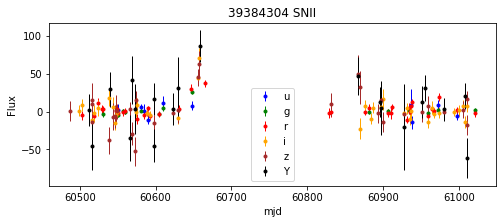

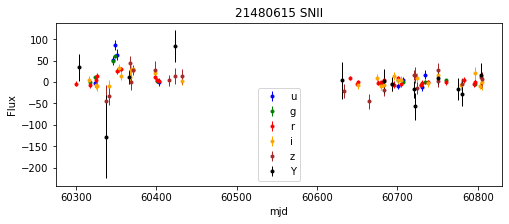

In [56]:
for snid in snids:
    plot_lc(str(snid), df_train, path='images/lightcurves/')
    plt.show()

Text(0.5, 1.0, 'Histograma de Flujos')

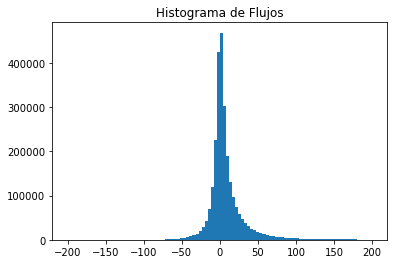

In [57]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(df_train.FLUXCAL.to_numpy(), bins=100, range=(-200,200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Flujos')

Text(0.5, 1.0, 'Histograma de los errores de los flujos')

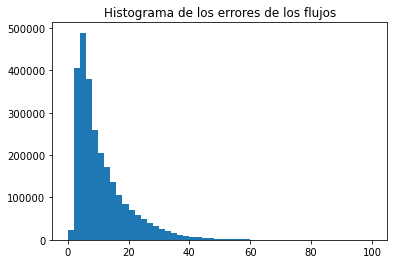

In [58]:
# Histograma de los errores 
counts, bins = np.histogram(df_train.FLUXCALERR.to_numpy(), bins=50, range=(0,100))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de los errores de los flujos')

Text(0.5, 1.0, 'Histograma de SNR')

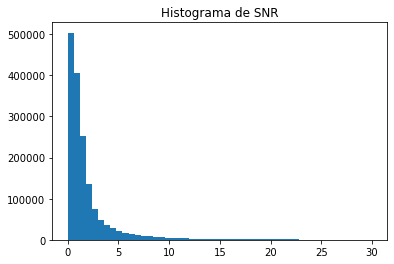

In [59]:
# Histograma SNR
counts, bins = np.histogram(df_train.FLUXCAL.to_numpy()/df_train.FLUXCALERR.to_numpy(), bins=50, range=(0,30))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de SNR')

In [ ]:
#Filtros (Colores de las galaxias)
df_train.insert(39, 'HOSTGAL_g-r', df_train.HOSTGAL_MAG_g - df_train.HOSTGAL_MAG_r)
df_train.insert(40, 'HOSTGAL_u-r', df_train.HOSTGAL_MAG_u - df_train.HOSTGAL_MAG_r)
df_train.insert(41, 'HOSTGAL_i-z', df_train.HOSTGAL_MAG_i - df_train.HOSTGAL_MAG_z)

df_train.insert(69, 'HOSTGAL2_g-r', df_train.HOSTGAL2_MAG_g - df_train.HOSTGAL2_MAG_r)
df_train.insert(70, 'HOSTGAL2_u-r', df_train.HOSTGAL2_MAG_u - df_train.HOSTGAL2_MAG_r)
df_train.insert(71, 'HOSTGAL2_i-z', df_train.HOSTGAL2_MAG_i - df_train.HOSTGAL2_MAG_z)
# No entrega info sobre si una galaxia es más roja o no, sino de la magnitud relativa g-r

### Features

Based on [Neira M. et. al. 2020](https://iopscience.iop.org/article/10.3847/1538-4365/aba267/pdf), some features based on magnitude are:
* **amp**: the difference between the maximum and minimum magnitudes
* **max_slope**: the maximum absolute slope between two consecutive observations.
* **mad**: the median of the difference between magnitudes and the median magnitude.
* **mbrp**: the ratio (percentage in the paper) of points within 10% of the median magnitude. 
* **pst**: the percentage of all pairs of consecutive magnitude measurements that have a positive slope.
* **pst_last30**: the percentage of the last 30 pairs of consecutive magnitudes that have a positive slope, minus percentage of the last 30 pairs of consecutive magnitudes with a negative slope.
* **rcb**: the percentage of data points whose magnitude is below 1.5 mag of the median.
* **ls**: the period of the peak frequency of the Lomb–Scargle periodogram (Scargle 1982).

In [60]:
def mag_features(SNID, df):
    # Needs to be modified. Eventually should add columns to dataframe with the features
    
    mask = (df.SNID == str(SNID))
    amp = df.loc[mask].FLUXCAL.max() - df.loc[mask].FLUXCAL.min()

    median_flux = df.loc[mask].FLUXCAL.median()
    over = (df.loc[mask].FLUXCAL / median_flux < 1.1)
    under = (df.loc[mask].FLUXCAL / median_flux > .9)
    mbrp = len(df.loc[mask].loc[(over) & (under)]) / len(df.loc[mask])
    
    #rcb = len(df.loc[mask].loc[df.loc[mask].FLUXCAL > 1.5 * median_flux]) / len(df.loc[mask])
    return [amp, mbrp] #, rcb]

Text(0.5, 1.0, 'Histograma de Redshifts')

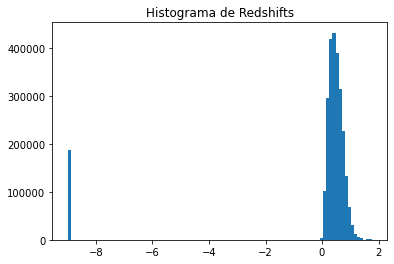

In [63]:
counts, bins = np.histogram(df_train.HOSTGAL_PHOTOZ.to_numpy(), bins=100)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Redshifts')

In [64]:
# d = z c / H0
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
HOSTGAL_DIST = df_train.loc[df_train.HOSTGAL_PHOTOZ != -9.0].HOSTGAL_PHOTOZ.to_numpy() * c.value * 10 ** (-3) / cosmo.H(0).value

In [65]:
LUM = 4 * np.pi * HOSTGAL_DIST ** 2 * df_train.FLUXCAL.loc[df_train.HOSTGAL_PHOTOZ != -9.0]

Text(0.5, 0, 'Distancia en Mpc')

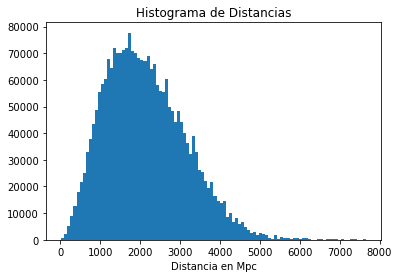

In [66]:
counts, bins = np.histogram(HOSTGAL_DIST, bins=100)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Distancias')
plt.xlabel('Distancia en Mpc')

Text(0.5, 0, 'Luminosidad')

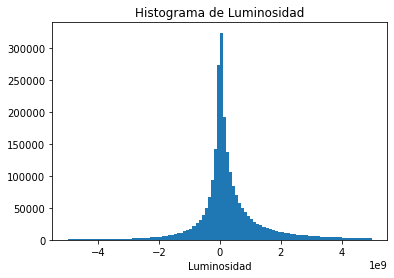

In [67]:
counts, bins = np.histogram(LUM, bins=100, range=(-.5* 10**10, .5*10**10))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Luminosidad')
plt.xlabel('Luminosidad')